In [1]:
from RobotRaconteur.Client import *
import time, sys, os
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from pandas import *
sys.path.append('toolbox')
from lambda_calc import *
from robot_def import *
from qpsolvers import solve_qp

In [10]:
import threading
class States_Realtime():
    def __init__(self,state_w):
        self.stop_event = threading.Event()
        self.state_w = state_w
        self._lock = threading.RLock()
        self.joint_position = []
        self.clock = []

    def start(self):
        self._checker = threading.Thread(target=self.get_states, args = (self.stop_event,))
        self._checker.daemon = True
        self._checker.start()

    def stop(self):
        self.stop_event.set()
        self._checker.join()

    def get_states(self,event):
        start_time = time.time()
        while not self.stop_event.is_set():
            while self._lock:
                time.sleep(0.01)
                self.joint_position.append(self.state_w.InValue.joint_position)
                self.clock.append(time.time())
                # check for stop
                if event.is_set():
                    self.joint_position = np.array(self.joint_position)
                    self.clock = np.array(self.clock)-start_time
                    return

In [11]:
time.sleep(5)
#select dataset
data_dir='data/wave/'
#select TCP
with open('config/tcp.yaml') as file:
    H_tcp = np.array(yaml.safe_load(file)['H'],dtype=np.float64)
robot=tormach(R_tool=H_tcp[:3,:3],p_tool=H_tcp[:-1,-1])

In [25]:
c = RRN.ConnectService('rr+tcp://[fe80::180d:c0c1:b05b:57f7]:11111/?nodeid=b1141357-a2c8-41dc-b16d-02dc9610ddea&service=tormach_robot')

cmd_w = c.position_command.Connect()
state_w = c.robot_state.Connect()
state_w.WaitInValueValid()

robot_const = RRN.GetConstants("com.robotraconteur.robotics.robot", c)
halt_mode = robot_const["RobotCommandMode"]["halt"]
trajectory_mode = robot_const["RobotCommandMode"]["trajectory"]
jog_mode = robot_const["RobotCommandMode"]["jog"]
position_mode = robot_const["RobotCommandMode"]["position_command"]

RobotJointCommand = RRN.GetStructureType("com.robotraconteur.robotics.robot.RobotJointCommand",c)

In [19]:
robot.fwd(state_w.InValue.joint_position).R

array([[-0.99996602,  0.00302212, -0.00767029],
       [-0.00049804,  0.90654464,  0.42210966],
       [ 0.00822913,  0.42209914, -0.90651233]])

In [20]:
###index trajectory with time
vd=50 		#mm/s
curve_js = read_csv(data_dir+'Curve_js.csv',header=None).values
lam=calc_lam_js(curve_js,robot)

lam_diff=np.gradient(lam)
dt=lam_diff/vd
t_traj=np.cumsum(dt)

In [21]:
JointTrajectoryWaypoint = RRN.GetStructureType("com.robotraconteur.robotics.trajectory.JointTrajectoryWaypoint",c)
JointTrajectory = RRN.GetStructureType("com.robotraconteur.robotics.trajectory.JointTrajectory",c)
waypoints = []

for i in range(len(curve_js)):

	wp = JointTrajectoryWaypoint()
	wp.joint_position = curve_js[i]
	wp.time_from_start = t_traj[i]
	waypoints.append(wp)
    
traj = JointTrajectory()
# traj.joint_names = [j.joint_identifier.name for j in c.robot_info.joint_info]
traj.joint_names=['joint_1','joint_2','joint_3','joint_4','joint_5','joint_6']
traj.waypoints = waypoints

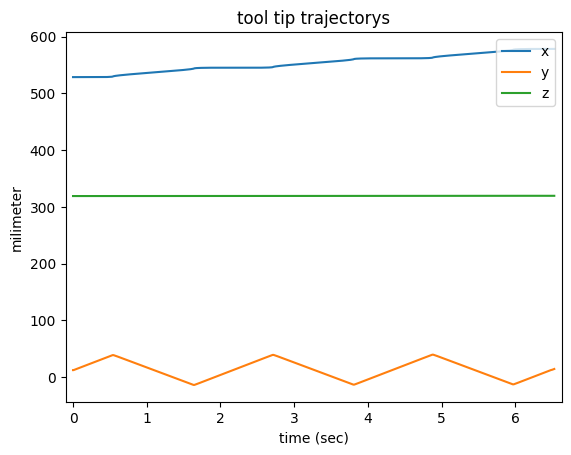

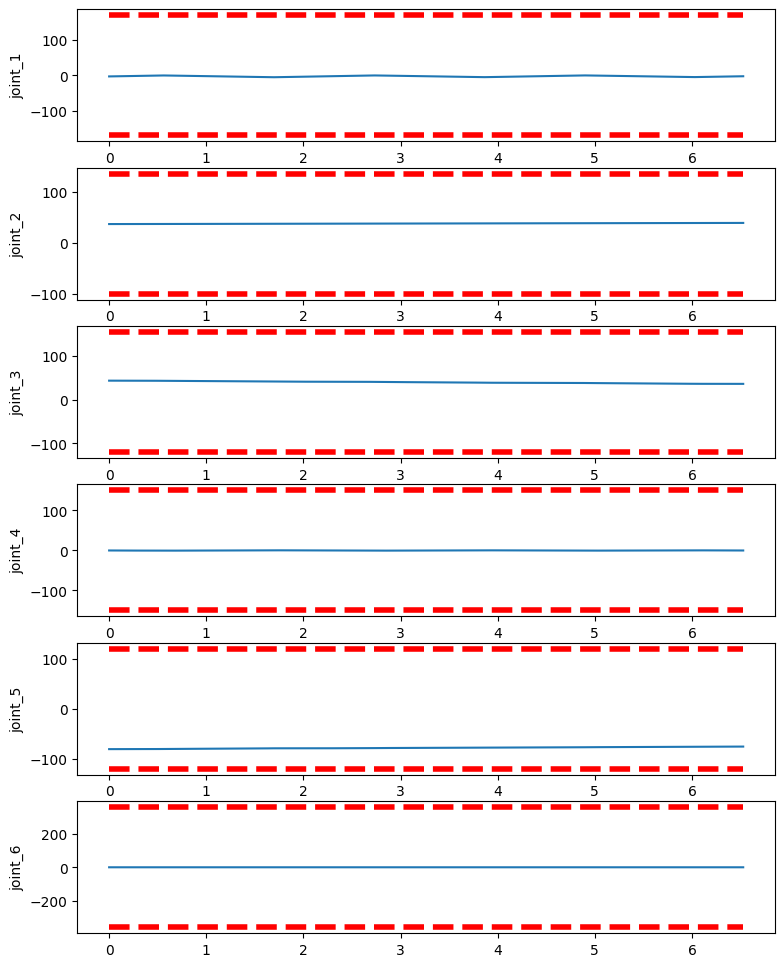

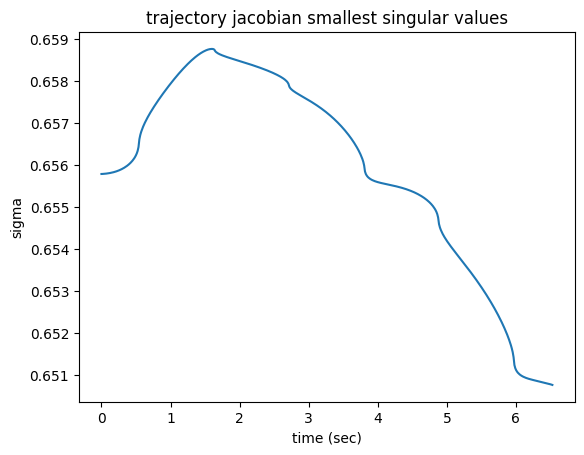

In [16]:
end_pose_calc = []
for q_calc in curve_js:
    robot_pose = robot.fwd(q_calc)
    end_pose_calc.append(robot_pose.p)
end_pose_calc = np.array(end_pose_calc)

plt.plot(t_traj,end_pose_calc)
plt.title('tool tip trajectorys')
plt.xlabel('time (sec)')
plt.ylabel('milimeter')
plt.legend(['x','y','z'])
plt.xlim([t_traj[0]-0.1, t_traj[-1]+0.1]) 
plt.show()

## evaluate angle limit
fig, axs = plt.subplots(6,1, figsize = (9, 12))
for idx, ax in enumerate(axs):
    ax.hlines(np.array([robot.lower_limit[idx], 
                        robot.upper_limit[idx]])*180/np.pi, 
              t_traj[0], t_traj[-1], 
              linestyles='dashed', color='red',linewidth=4)
    ax.plot(t_traj, curve_js[:,idx]*180/np.pi)
    ax.set_ylabel(traj.joint_names[idx])

## evaluate jacobian for singularities
svd_J = []
for q_calc in curve_js:
    robot_J = robot.jacobian(q_calc)
    u,s,vh = np.linalg.svd(robot_J)
    svd_J.append(s)
svd_J = np.array(svd_J)
fig2, ax2 = plt.subplots()
plt.plot(t_traj,np.min(svd_J, axis = 1))
plt.title('trajectory jacobian smallest singular values')
plt.xlabel('time (sec)')
plt.ylabel('sigma')
#plt.legend(traj.joint_names)
plt.show()

In [26]:
# c.command_mode = halt_mode
# time.sleep(0.1)
# c.command_mode = jog_mode

# c.jog_freespace(curve_js[0],np.ones(6),True) ## true is to wait
# print('jog complete')



c.command_mode = halt_mode
time.sleep(0.1)
c.command_mode = trajectory_mode

In [27]:
traj_gen = c.execute_trajectory(traj)
rt_state = States_Realtime(state_w)
rt_state.start()
while (True):
    try:
        res = traj_gen.Next()
    except RR.StopIterationException:
        rt_state.stop()
        print('completed')
        break

KeyboardInterrupt: 

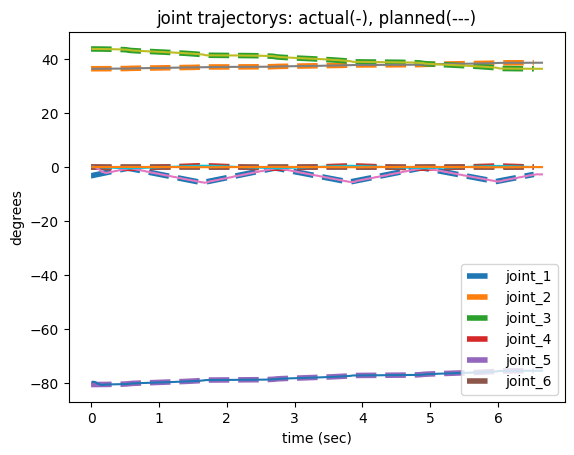

In [24]:
plt.plot(t_traj,curve_js*180/np.pi,'--', linewidth = 4)
plt.plot(rt_state.clock,rt_state.joint_position*180/np.pi)
plt.title('joint trajectorys: actual(-), planned(---)')
plt.xlabel('time (sec)')
plt.ylabel('degrees')
plt.legend(traj.joint_names)
plt.show()

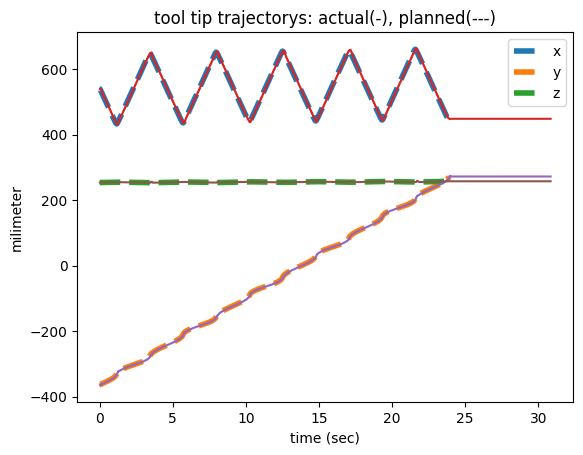

In [145]:
end_pose_calc = []
end_pose_real = []
for q_calc in curve_js:
    robot_pose = robot.fwd(q_calc)
    end_pose_calc.append(robot_pose.p)
for q_real in rt_state.joint_position:
    robot_pose = robot.fwd(q_real)
    end_pose_real.append(robot_pose.p)
end_pose_calc = np.array(end_pose_calc)
end_pose_real = np.array(end_pose_real)

plt.plot(t_traj,end_pose_calc,'--',linewidth = 4)
plt.plot(rt_state.clock,end_pose_real)
plt.title('tool tip trajectorys: actual(-), planned(---)')
plt.xlabel('time (sec)')
plt.ylabel('milimeter')
plt.legend(['x','y','z'])
plt.show()

In [10]:
# robot top up position
q_top = state_w.InValue.joint_position
p_top = robot.fwd(state_w.InValue.joint_position).p
print('p_top of the working surface: \n', p_top, '\nq_top\n', q_top)

p_top of the working surface: 
 [424.30019539   9.82342322 447.37376227] 
q_top
 [ 0.02800324  0.10323387  0.97900178  0.02503888 -1.08053692 -0.4411165 ]


In [21]:
c.command_mode = halt_mode
time.sleep(0.1)
c.command_mode = jog_mode

c.jog_freespace(q_top,np.ones(6)*0.5,True) ## true is to wait
print('jog complete')

jog complete


In [9]:
## obtain three points real
p1 = robot.fwd(state_w.InValue.joint_position).p
print('p1 of the working surface: \n', p1)

p1 of the working surface: 
 [ 437.35818945 -136.22930334  247.1871852 ]


In [10]:
p2 = robot.fwd(state_w.InValue.joint_position).p
print('p2 of the working surface: \n', p2)

p2 of the working surface: 
 [ 629.48240844 -136.20897693  247.99329657]


In [11]:
p3 = robot.fwd(state_w.InValue.joint_position).p
print('p3 of the working surface: \n', p3)

p3 of the working surface: 
 [439.51369029 120.6516261  245.67262581]


In [23]:
def move(vd, ER):
    global vel_ctrl
    try:
        w=1.
        Kq=.01*np.eye(6)    #small value to make sure positive definite
        KR=np.eye(3)        #gains for position and orientation error

        q_cur=vel_ctrl.joint_position()
        J=robot.jacobian(q_cur)       #calculate current Jacobian
        Jp=J[3:,:]
        JR=J[:3,:] 
        H=np.dot(np.transpose(Jp),Jp)+Kq+w*np.dot(np.transpose(JR),JR)

        H=(H+np.transpose(H))/2


        k,theta = R2rot(ER)
        k=np.array(k)
        s=np.sin(theta/2)*k         #eR2
        wd=-np.dot(KR,s)  
        f=-np.dot(np.transpose(Jp),vd)-w*np.dot(np.transpose(JR),wd)
        ###Don't put bound here, will affect cartesian motion outcome
        qdot=solve_qp(H, f,solver = 'quadprog')
        # print(qdot)
        ###For safty, make sure robot not moving too fast
        if np.max(np.abs(qdot))>1.0:
            qdot=np.zeros(6)
            print('too fast')
        vel_ctrl.set_velocity_command(qdot)
    except:
        traceback.print_exc()
    return


def stop():
	global vel_ctrl
	vel_ctrl.set_velocity_command(np.zeros((6,)))
	return


def normalize_dq(q):
	q[:-1]=q[:-1]/(np.linalg.norm(q[:-1])) 
	return q   

In [19]:
# enable velocity control
from vel_emulate_sub import EmulatedVelocityControl
robot_sub = RRN.SubscribeService('rr+tcp://[fe80::180d:c0c1:b05b:57f7]:11111/?nodeid=b1141357-a2c8-41dc-b16d-02dc9610ddea&service=tormach_robot')
# robot_sub=RRN.SubscribeService('rr+tcp://pathpilot:11111?service=tormach_robot')
rob = robot_sub.GetDefaultClientWait(1)
state_w = robot_sub.SubscribeWire("robot_state")
cmd_w = robot_sub.SubscribeWire("position_command")
vel_ctrl = EmulatedVelocityControl(rob,state_w, cmd_w)
RobotJointCommand = RRN.GetStructureType("com.robotraconteur.robotics.robot.RobotJointCommand",rob)

rob.command_mode = halt_mode
time.sleep(0.1)
rob.command_mode = position_mode

In [32]:
# autonumous calibration from force sensor
vel_ctrl.enable_velocity_mode()
print('TCP pose', robot.fwd(vel_ctrl.joint_position()).p)
v_sense = 0.1 # mm/s
timeout = time.time() + 3
while True:
    move(np.array([0,0,1])*v_sense, np.eye(3))
    if time.time() > timeout:
        break
stop()
print('TCP pose', robot.fwd(vel_ctrl.joint_position()).p)
vel_ctrl.disable_velocity_mode()

TCP pose [ 508.53374913 -244.57147415  390.14601558]
TCP pose [ 508.55189026 -244.57886683  390.27668672]


In [1]:
pwd

'C:\\Users\\kongc\\Dropbox\\RPI_2022FALL\\MasterThesis\\tormach_za6_subtractive_mftg'

In [13]:
if os.path.exists('home_joint_angles.npy'):
    with open('home_joint_angles.npy', 'rb') as f:
        q_top = np.load(f)
    print('Found and loaded home joint config:\n',
          q_top)
else:
    with open('home_joint_angles.npy', 'wb') as f:
        np.save(f, q_top)
    print('Saved home joint config:\n',
          q_top)


if os.path.exists('surface_points.npy'):
    with open('surface_points.npy', 'rb') as f:
        p1 = np.load(f)
        p2 = np.load(f)
        p3 = np.load(f)
    print('Found and loaded calibrated surface points:\n',
          p1, '\n', p2, '\n', p3)
else:
    with open('surface_points.npy', 'wb') as f:
        np.save(f, p1)
        np.save(f, p2)
        np.save(f, p3)
    print('Saved calibrated surface points:\n',
          p1, '\n', p2, '\n', p3)

x_p = (p2-p1)/np.linalg.norm(p2-p1)
z_p = np.cross(x_p,p3-p1)/np.linalg.norm(np.cross(x_p,p3-p1))
y_p = np.cross(z_p, x_p)
N = z_p
d = p2.dot(N)
N,d

Found and loaded home joint config:
 [ 0.02800324  0.10323387  0.97900178  0.02503888 -1.08053692 -0.4411165 ]
Found and loaded calibrated surface points:
 [ 437.35818945 -136.22930334  247.1871852 ] 
 [ 629.48240844 -136.20897693  247.99329657] 
 [439.51369029 120.6516261  245.67262581]


(array([-0.0041963 ,  0.00593101,  0.99997361]), 244.5373974529294)

In [19]:
from manual_guiding import manual_guiding
manual_tormach = manual_guiding()
manual_tormach.start()

ConnectionException: RobotRaconteur.ConnectionError Could not find any valid transports for requested connection URLs

In [ ]:
manual_tormach.stop()

In [ ]:
## tormach_machining abundant traj mode
### enter trajectory mode
        self.robot.command_mode = self.halt_mode
        time.sleep(0.1)
        self.robot.command_mode = self.trajectory_mode
        
        JointTrajectoryWaypoint = RRN.GetStructureType("com.robotraconteur.robotics.trajectory.JointTrajectoryWaypoint",self.robot)
        JointTrajectory = RRN.GetStructureType("com.robotraconteur.robotics.trajectory.JointTrajectory",self.robot)
        waypoints = []

        for i in range(len(curve_js)):
            wp = JointTrajectoryWaypoint()
            wp.joint_position = curve_js[i]
            wp.time_from_start = t_traj[i]
            waypoints.append(wp)

        traj = JointTrajectory()
        # traj.joint_names = [j.joint_identifier.name for j in c.robot_info.joint_info]
        traj.joint_names=['joint_1','joint_2','joint_3','joint_4','joint_5','joint_6']
        traj.waypoints = waypoints
        
        traj_gen = self.robot.execute_trajectory(traj)
        
        print('robot trajectory mode begin')
        # rt_state = States_Realtime(state_w)
        # rt_state.start()
        traj_gen.Next()
        # while (True):
        #     try:
        #         res = traj_gen.Next()
        #     except RR.StopIterationException:
        #         # rt_state.stop()
        #         print('completed')
        #         break
        self.robot.command_mode = self.halt_mode

In [1]:
    def load_traj(self, data_path = 'data/wave/'):
        curve_js = read_csv(data_path+'Curve_js.csv',header=None).values
        lam=calc_lam_js(curve_js,self.robot_toolbox)

        lam_diff=np.gradient(lam)
        dt=lam_diff/self.vd
        t_traj=np.cumsum(dt)
        return curve_js, t_traj
        
        
    def eval_traj(self, curve_js, t_traj):
        end_pose_calc = []
        for q_calc in curve_js:
            robot_pose = self.robot_toolbox.fwd(q_calc)
            end_pose_calc.append(robot_pose.p)
        end_pose_calc = np.array(end_pose_calc)

        plt.plot(t_traj,end_pose_calc)
        plt.title('tool tip trajectorys')
        plt.xlabel('time (sec)')
        plt.ylabel('milimeter')
        plt.legend(['x','y','z'])
        plt.xlim([t_traj[0]-0.1, t_traj[-1]+0.1]) 
        plt.show()

        ## evaluate angle limit
        fig, axs = plt.subplots(6,1, figsize = (9, 12))
        joint_names = ['joint_1','joint_2','joint_3','joint_4','joint_5','joint_6']
        for idx, ax in enumerate(axs):
            ax.hlines(np.array([self.robot_toolbox.lower_limit[idx], 
                                self.robot_toolbox.upper_limit[idx]])*180/np.pi, 
                      t_traj[0], t_traj[-1], 
                      linestyles='dashed', color='red',linewidth=4)
            ax.plot(t_traj, curve_js[:,idx]*180/np.pi)
            ax.set_ylabel(joint_names[idx])

        ## evaluate jacobian for singularities
        svd_J = []
        for q_calc in curve_js:
            robot_J = self.robot_toolbox.jacobian(q_calc)
            u,s,vh = np.linalg.svd(robot_J)
            svd_J.append(s)
        svd_J = np.array(svd_J)
        fig2, ax2 = plt.subplots()
        plt.plot(t_traj,np.min(svd_J, axis = 1))
        plt.title('trajectory jacobian smallest singular values')
        plt.xlabel('time (sec)')
        plt.ylabel('sigma')
        #plt.legend(traj.joint_names)
        plt.show()
    
    
    def jog_traj(self, curve_js, t_traj):
        
        ### first jog to the starting point of the trajectory
        self.robot.command_mode = self.halt_mode
        time.sleep(0.1)
        self.robot.command_mode = self.position_mode
        ## enable velocity emulation
        self.vel_ctrl.enable_velocity_mode()
        print('velocity control enabled')
        ## jog the robot to starting point
        self.jog_joint(curve_js[0], 1, threshold=0.01) 
        time.sleep(2)
        
        ### jog robot through the way points according to time stamp
        ## get q_dot of the whole path in rad/sec 
        t_diff = np.diff(t_traj)
        qdot_all = np.diff(curve_js, axis=0)/t_diff[:,np.newaxis]
        ## start join measurment thread
        rt_joint = Joint_Realtime(self.vel_ctrl)
        rt_joint.start()
        for step, qdot in enumerate(qdot_all):
            s_time = time.time()
            q_cur=self.vel_ctrl.joint_position()
            qdot += (curve_js[step]-q_cur)/t_diff[step]
            # print((curve_js[step]-q_cur)/t_diff[step])
            self.vel_ctrl.set_velocity_command(qdot)
            diff_time = time.time()-s_time
            time.sleep(t_diff[step]/1.5)
        rt_joint.stop()
        
        self.vel_ctrl.set_velocity_command(np.zeros(6))
        self.vel_ctrl.disable_velocity_mode()
        print('velocity control disabled')
        
        end_pose_calc = []
        end_pose_real = []
        for q_calc in curve_js:
            robot_pose = self.robot_toolbox.fwd(q_calc)
            end_pose_calc.append(robot_pose.p)
        for q_real in rt_joint.joint_position:
            robot_pose = self.robot_toolbox.fwd(q_real)
            end_pose_real.append(robot_pose.p)
        end_pose_calc = np.array(end_pose_calc)
        end_pose_real = np.array(end_pose_real)

        plt.plot(t_traj,end_pose_calc,'--',linewidth = 4)
        plt.plot(rt_joint.clock,end_pose_real)
        plt.title('tool tip trajectorys: actual(-), planned(---)')
        plt.xlabel('time (sec)')
        plt.ylabel('milimeter')
        plt.legend(['x','y','z'])
        plt.show()

In [8]:
import yaml
with open('config/ati_pose_old.yaml') as tool_file:
    H_ati=np.array(yaml.safe_load(tool_file)['H'], dtype=np.float64)
print(H_ati)
H_ati[:3,:3] = Rx(25*np.pi/180)@H_ati[:3,:3]
print(H_ati)
with open('config/ati_pose.yaml', 'w') as f:
    yaml.dump(H_ati.tolist(), f)

[[ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]
[[ 0.          0.          1.          0.        ]
 [ 0.42261826  0.90630779  0.          0.        ]
 [-0.90630779  0.42261826  0.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [9]:
with open('config/default_tcp_old.yaml') as tool_file:
    H_tcp=np.array(yaml.safe_load(tool_file)['H'], dtype=np.float64)
print(H_tcp)
H_tcp[:3,:3] = Rx(25*np.pi/180)@H_tcp[:3,:3]
print(H_tcp)
with open('config/default_tcp.yaml', 'w') as f:
    yaml.dump(H_tcp.tolist(), f)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779 -0.42261826  0.        ]
 [ 0.          0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]
